In [1]:
import matplotlib.pyplot as plt
import sloper

dataset = sloper.Dataset('..\src\sample.tif')
slope_list = []

for i in range(7):
    slope_list.append(dataset.slope(i, format = 'degree'))

print(slope_list)

[array([[11.42175366, 27.25203367, 32.5735557 , ...,  8.13010235,
         8.13010235, 11.42175366],
       [27.25203367, 38.94244127, 35.53767779, ..., 11.42175366,
        11.42175366, 15.9453959 ],
       [27.25203367, 31.21969845, 31.21969845, ...,  8.13010235,
        15.9453959 , 15.9453959 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]]), array([[14.6388066 , 27.91778359, 32.5735557 , ...,  6.23982645,
         9.40079003,  8.13010235],
       [27.91778359, 34.5969529 , 35.31160751, ...,  8.78988747,
        11.88819991, 13.89788625],
       [27.25203367, 33.73861902, 33.73861902, ..., 10.72363245,
        13.89788625, 15.9453959 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        

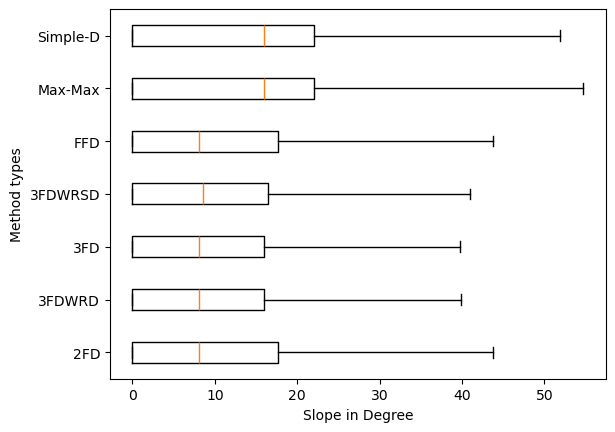

In [2]:
flatten_slope = [x.flatten() for x in slope_list]

fix, ax = plt.subplots()
ax.boxplot(flatten_slope, positions = range(7), widths = 0.4, showfliers = False, vert = False)
ax.set(yticks = range(7), yticklabels = ['2FD', '3FDWRD', '3FD', '3FDWRSD', 'FFD', 'Max-Max', 'Simple-D'])
ax.set(xlabel = 'Slope in Degree', ylabel = 'Method types')

plt.show()

## Fill NaNs

See `sloper.Utils.fill_na()`.

In [3]:
import numpy as np
from scipy import ndimage

def fill_nan_demo():
    dem = np.array([[0, 1, 5, 2], [np.nan, 3, 4, np.nan], [np.nan, np.nan, 2, 3], [np.nan ,np.nan, 1, 4]])
    new_dem = dem.copy()
    print('Original DEM:')
    print(dem, end = '\n\n')

    win = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]])

    non_nan_neighbor = ndimage.convolve(1 - np.isnan(dem).astype(int), win, mode = 'constant')
    print('Neighbor non-NaN counts:')
    print(non_nan_neighbor, end = '\n\n')

    summation = ndimage.convolve(np.nan_to_num(dem), win, mode = 'constant')
    print('Neighbor summation:')
    print(summation, end = '\n\n')

    valid_mask = np.isnan(dem) & (non_nan_neighbor > 1)
    print('Valid mask:')
    print(valid_mask, end = '\n\n')

    with np.errstate(divide = 'ignore', invalid = 'ignore'):
        # Ignore divide by 0 and nan warnings
        np.putmask(new_dem, valid_mask, summation / non_nan_neighbor)
    print('New DEM:')
    print(new_dem)

fill_nan_demo()

Original DEM:
[[ 0.  1.  5.  2.]
 [nan  3.  4. nan]
 [nan nan  2.  3.]
 [nan nan  1.  4.]]

Neighbor non-NaN counts:
[[2 4 4 2]
 [3 5 6 5]
 [1 4 5 4]
 [0 2 3 3]]

Neighbor summation:
[[ 4. 12. 10.  9.]
 [ 4. 12. 16. 16.]
 [ 3. 10. 15. 11.]
 [ 0.  3.  9.  6.]]

Valid mask:
[[False False False False]
 [ True False False  True]
 [False  True False False]
 [False  True False False]]

New DEM:
[[0.         1.         5.         2.        ]
 [1.33333333 3.         4.         3.2       ]
 [       nan 2.5        2.         3.        ]
 [       nan 1.5        1.         4.        ]]
